#Import loibraries and check hardware

In [1]:
!pip install yfinance --quiet

In [2]:
import math, numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf

print("TensorFlow:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#Import Dataset

In [3]:
ticker = "AAPL"
start_date = "2015-01-01"
end_date = "2025-09-10"


In [4]:
df = yf.download(ticker, start=start_date, end=end_date)


/tmp/ipython-input-3882796689.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [5]:
df = df[['Close']].dropna()


In [6]:
df.head()


Price,Close
Ticker,AAPL
Date,
2015-01-02,24.261047
2015-01-05,23.577574
2015-01-06,23.579800
2015-01-07,23.910439
2015-01-08,24.829126


#Preprocessing

In [7]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df.values)
# Normalizes prices between 0 and 1 (LSTM trains better on normalized values).

In [8]:
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])   # sequence of past 'seq_len' days
        y.append(data[i+seq_len])     # the value right after the sequence
    return np.array(X), np.array(y)


In [9]:
SEQ_LEN = 60
X, y = create_sequences(scaled, SEQ_LEN)


In [10]:
X = X.reshape((X.shape[0], X.shape[1], 1))


In [11]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [12]:
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2101, 60, 1) (2101, 1)
Test shape: (526, 60, 1) (526, 1)


#Build RNN LSTM model

In [13]:
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1)
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [15]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,033 (453.25 KB)

 Trainable params: 116,033 (453.25 KB)

 Non-trainable params: 0 (0.00 B)

#Train model

In [16]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [17]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=64,
    callbacks=[es],
    verbose=1
)


Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 0.0282 - mae: 0.1063 - val_loss: 0.0016 - val_mae: 0.0318
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0011 - mae: 0.0217 - val_loss: 0.0014 - val_mae: 0.0298
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.0765e-04 - mae: 0.0195 - val_loss: 0.0016 - val_mae: 0.0316
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.7095e-04 - mae: 0.0198 - val_loss: 0.0012 - val_mae: 0.0269
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.1184e-04 - mae: 0.0180 - val_loss: 0.0010 - val_mae: 0.0250
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.5363e-04 - mae: 0.0184 - val_loss: 0.0012 - val_mae: 0.0271
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.9570e-04 - mae: 0.0175 - val_loss: 0.0015 - val_mae: 0.0305
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.5207e-04 - mae: 0.0172 - val_loss: 0.0018 - val_mae: 0.0337
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s

#Evaluate the model

In [18]:
pred_scaled = model.predict(X_test)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [19]:
pred = scaler.inverse_transform(pred_scaled)
actual = scaler.inverse_transform(y_test.reshape(-1,1))


In [20]:
rmse = math.sqrt(mean_squared_error(actual, pred))
mae = mean_absolute_error(actual, pred)
print("RMSE:", rmse, "MAE:", mae)


RMSE: 7.624791939725835 MAE: 5.933898113526319


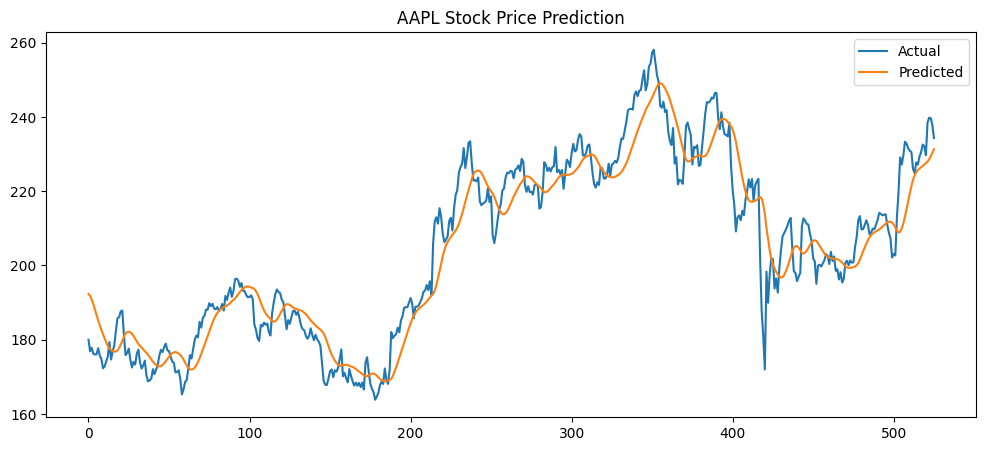

In [21]:
plt.figure(figsize=(12,5))
plt.plot(actual, label="Actual")
plt.plot(pred, label="Predicted")
plt.title(f"{ticker} Stock Price Prediction")
plt.legend()
plt.show()


#Forecast feature values

In [22]:
N_DAYS = 7
last_seq = scaled[-SEQ_LEN:]   # last 60 days data
current_seq = last_seq.copy()
future_preds = []


In [25]:
for _ in range(N_DAYS):
    pred_scaled = model.predict(current_seq.reshape(1, SEQ_LEN, 1))[0]
    future_preds.append(pred_scaled)
    current_seq = np.append(current_seq[1:], pred_scaled.reshape(1, 1), axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [26]:
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1,1))
print(f"Next {N_DAYS} days prediction:")
print(future_preds.flatten())


Next 7 days prediction:
[231.98112 231.98112 231.98112 232.38719 232.59026 232.64821 232.60484
 232.49257 232.33469]
